<a href="https://colab.research.google.com/github/shamim-hussain/sequence_models_and_word_embeddings/blob/main/sequence_models_and_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

## Targeted Task

We will perform sentiment analysis on the **IMDB movie reviews dataset**. It is a dataset of 50000 (text) reviews which are categorized as either positive or negative depending on the review scores. The link to the dataset:

https://ai.stanford.edu/~amaas/data/sentiment/

This problem is appropriate for sequence modeling because the sequence in which the words appear in the text is important to properly represent their meaning. So we will apply a Recurrent Neural Network on the word embeddings in the text in a sequential manner and the classification will be performed based on the final output of the RNN, which should represent the overall sentiment expressed within the text.

We will use **Tensorflow** with the **Keras** high level framework to implement our model. We will also use the pretrained GloVe word embeddings to initialize our input word embeddings in order to get better classification results via transfer learning.

## Preprocessing

### Download and read text

First we will download and extract the dataset.


In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xvf aclImdb_v1.tar.gz

Next we will read the text review files, both positive and negative.

In [1]:
from pathlib import Path

base_path = Path('aclImdb')

train_pos_txt = list(f.read_text(encoding="utf-8") for f in (base_path/'train'/'pos').glob('*.txt'))
train_neg_txt = list(f.read_text(encoding="utf-8") for f in (base_path/'train'/'neg').glob('*.txt'))
test_pos_txt = list(f.read_text(encoding="utf-8") for f in (base_path/'test'/'pos').glob('*.txt'))
test_neg_txt = list(f.read_text(encoding="utf-8") for f in (base_path/'test'/'neg').glob('*.txt'))

print('Positive sample 0:')
print(train_pos_txt[0])
print()
print('Negative sample 0:')
print(train_neg_txt[0])

Positive sample 0:
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

Negative sample 0:
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audie

Let us combine the positive and negative reviews and add corresponding labels to them (1: positive, 0:negative).

In [2]:
import numpy as np

X_train_txt = train_pos_txt + train_neg_txt
Y_train = np.array([1] * len(train_pos_txt) + [0] * len(train_neg_txt))

X_test_txt = test_pos_txt + test_neg_txt
Y_test = np.array([1] * len(test_pos_txt) + [0] * len(test_neg_txt))

### Lemmatization and Tokenization

We cannot train our model with the raw text. First we will separate the tokens and optionally lemmatize them. Lemmatization will reduce each word to their base form and thus allow for a smaller vocabulary. This will save resources and also possibly prevent overfitting.

We will use the SpaCy library for lemmatization.

In [ ]:
!python -m spacy download en_core_web_sm

import spacy
import re
nlp = spacy.load('en_core_web_sm')
clean_regex = re.compile('<.*?>')  # To remove tags such as <br/></br> 

def text_data_cleaning(sentence):
    sentence = re.sub(clean_regex, ' ', sentence)
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        if token.lemma_ != "-PRON-":
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_
        tokens.append(temp)
    return tokens


Let us look at the a sample lemmatized text.

In [ ]:
print('Original:')
print(X_train_txt[0])
print('Tokenized and lemmatized:')
print(text_data_cleaning(X_train_txt[0]))

We see that the basic sense of the text is still conveyed by the lemmatized tokens.

Now we will tokenize and lemmatize the whole dataset.

In [4]:
import numpy as np
from tqdm import tqdm

try:
    data = np.load('imdb.npz',allow_pickle=True)
    X_train_tokens = data['X_train_tokens']
    X_test_tokens = data['X_test_tokens']
    data.close()
except FileNotFoundError:
    X_train_tokens = []
    for sample in tqdm(X_train_txt, desc='Processing training files'):
        X_train_tokens.append(text_data_cleaning(sample))

    X_test_tokens = []
    for sample in tqdm(X_test_txt, desc='Processing test files'):
        X_test_tokens.append(text_data_cleaning(sample))

    X_train_tokens=np.array(X_train_tokens, dtype=object)
    X_test_tokens=np.array(X_test_tokens, dtype=object)

    np.savez('imdb.npz', 
             X_train_tokens = X_train_tokens,
             Y_train = Y_train,
             X_test_tokens = X_test_tokens,
             Y_test = Y_test)

## Building vocabulary and conversion into sequences

We will limit our vocabulary to 2000 most frequent tokens. Also we will truncate and pad the sequences so that they have a uniform length of 512 tokens. The padded parts (with a value of 0) will be masked and the model will effectively ignore these parts.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 2000
max_len = 512

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train_tokens)

X_train = tokenizer.texts_to_sequences(X_train_tokens)
X_test = tokenizer.texts_to_sequences(X_test_tokens)

X_train = pad_sequences(X_train, maxlen=max_len, dtype='int32', padding='post',
                        truncating='post', value=0)
X_test = pad_sequences(X_test, maxlen=max_len, dtype='int32', padding='post',
                        truncating='post', value=0)

The text can be partiallly reconstructed from the sequences by looking up the vocabulary. For example:

In [6]:
print('Sequence:')
print(X_train[0])
print('Reconstructed:')
print(tokenizer.sequences_to_texts(X_train[0:1])[0])

Sequence:
[ 738  598 1142   30    1   27   19    1 1565   50    1   11    7    1
  700  223   38  101   96   10    5    6    2    1  246    9    1    1
    5  877    6    1   11    2 1216    1  302 1142    8    2    1    4
  738  598 1142    3  417 1635    6  527  634    5    6 1565  671  138
    2    1   24   33  636    1 1804    6    1    1    4   19    3    2
  124  134    2  352   60  437    4    3    1    1  411   22    7    1
    5  228 1368  407   60  437    4   25 1565  430    7  530   60   63
    5   29   17    9   70    6   37    4   10  131  251   71    5    6
   10  107   85   41  575    2  101   59   12   37   10    4   28  292
 1383    1    5   12    3  907   38  102   63   10  466   71    5  102
   63    1   10    3    5    6  102    1    6  164   10    3   38    2
  182   59    4   19  152    1    1   30   44   98  257  221   27    3
   96   64   23   33  253  123    5   26   24    1    6   13   21   32
   84    7    1  354   24    1  124    4   10    3  408   41  112  

### Train-Validation split
Let us split the training dataset to reserve some data for validation.

In [7]:
from sklearn.model_selection import train_test_split
X_train,  X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size=.075, stratify=Y_train,
                                                  shuffle=True,random_state=123)

## Model Definition, Training and Evaluation

### Preparing pretrained word embeddings
We will use the GloVe word embeddings to initialize the input word embeddings. These embeddings are openly available at:

https://nlp.stanford.edu/projects/glove/

We will (downlad and) match each word in our vocabulary to the embedding vector provided for that word to form an embedding matrix. If that particular word/token is not present, it is randomly initialized.

In [9]:
import os

embedding_dim = 100

embedding_file_path = f'glove.6B.{embedding_dim}d.txt'

if not os.path.exists(embedding_file_path):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

embeddings_index = {}
with open(embedding_file_path, 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("\nFound %s word vectors." % len(embeddings_index))

embedding_matrix = np.random.uniform(size=(vocab_size, embedding_dim)).astype('float32')

for i in range(vocab_size):
    try:
        embedding_matrix[i] = embeddings_index[tokenizer.index_word[i]]
    except KeyError:
        pass

400000it [00:14, 28156.79it/s]


Found 400000 word vectors.


### Simple RNN

First we will try to solve this problem with a simple RNN. The state update equation - 

$$\mathbf{h}_{t+1} = \tanh(\mathbf{W}_h \mathbf{h}_t + \mathbf{W}_x \mathbf{x}_t + \mathbf{b} )$$

Where,
> $\mathbf{h}_t$ is the state at step $t$ \\
> $\mathbf{x}_t$ is the input at step $t$ \\
> $\mathbf{W}_h$ is the recurrent kernel \\
> $\mathbf{W}_x$ is the input kernel \\
> $\mathbf{b}$ is the bias \\
> $\tanh$ is the activation function \\
> $\mathbf{h}_{t+1}$ is the state at step $t+1$ \\

Classification is done based on the final state.

Since this is a binary classification problem we sill use **accuracy** as the metric.


#### Model definition and Training
Embeddings are intialized with the pretrained embeddings. Padded (0 values) tokens are maked out. We will use the "SimpleRNN" layer for keras. The Adam optimizer with a moderate learning rate ($5\times10^{-4}$) and gradient clipping is used. Binary crossentropy is used as loss function.

In [13]:
from tensorflow.keras import models, layers, initializers, optimizers, losses, metrics

model_layers = []
model_layers.append(layers.Embedding(vocab_size, 
                               embedding_dim, 
                               embeddings_initializer=initializers.Constant(embedding_matrix), 
                               mask_zero=True,
                               input_shape=[max_len]))
model_layers.append(layers.SimpleRNN(units=256,
                                     activation='tanh', use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     recurrent_initializer='orthogonal',
                                     bias_initializer='zeros'))
model_layers.append(layers.Dense(1, activation=None))

model = models.Sequential(model_layers, name='rnn_model',)

loss = losses.BinaryCrossentropy(from_logits=True)
acc = metrics.BinaryAccuracy(name='acc')
optim = optimizers.Adam(learning_rate=5e-4, clipvalue=.5)

model.compile(optimizer=optim, loss=loss, metrics=[acc])
model.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 512, 100)          200000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 256)               91392     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 291,649
Trainable params: 291,649
Non-trainable params: 0
_________________________________________________________________


Let's train the model.

In [14]:
history_simple_rnn =model.fit(X_train, Y_train, batch_size=32, epochs=15, validation_data=(X_val,Y_val))

Epoch 1/15
723/723 [==============================] - 291s 402ms/step - loss: 0.6857 - acc: 0.5470 - val_loss: 0.6381 - val_acc: 0.5920
Epoch 2/15
723/723 [==============================] - 277s 383ms/step - loss: 0.6412 - acc: 0.6044 - val_loss: 0.8291 - val_acc: 0.5643
Epoch 3/15
723/723 [==============================] - 284s 392ms/step - loss: 0.6305 - acc: 0.6160 - val_loss: 0.6573 - val_acc: 0.5776
Epoch 4/15
723/723 [==============================] - 292s 404ms/step - loss: 0.5795 - acc: 0.6760 - val_loss: 0.5874 - val_acc: 0.6117
Epoch 5/15
723/723 [==============================] - 297s 411ms/step - loss: 0.6242 - acc: 0.6098 - val_loss: 0.6400 - val_acc: 0.6624
Epoch 6/15
723/723 [==============================] - 279s 386ms/step - loss: 0.6468 - acc: 0.5760 - val_loss: 0.6448 - val_acc: 0.5547
Epoch 7/15
723/723 [==============================] - 286s 395ms/step - loss: 0.6241 - acc: 0.6160 - val_loss: 0.6602 - val_acc: 0.5280
Epoch 8/15
723/723 [============================

We get a final validation accuracy of 57.97% which is not very good. However, the real problem can be seen from the training curves:

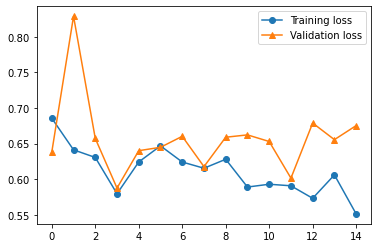

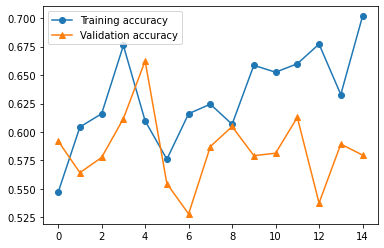

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=[6,4])
plt.plot(history_simple_rnn.history['loss'], marker= 'o', label='Training loss')
plt.plot(history_simple_rnn.history['val_loss'], marker='^', label='Validation loss')
_=plt.legend()

plt.figure(figsize=[6,4])
plt.plot(history_simple_rnn.history['acc'], marker= 'o', label='Training accuracy')
plt.plot(history_simple_rnn.history['val_acc'], marker='^', label='Validation accuracy')
_=plt.legend()

W see that we have pathological training curves with training and validation losses fluctating randomly and training and validation accuracies also showing random fluctation. This is due to the vanishing and exploding gradients which make optimizing this simple rnn over very long contexts (upto 512 time steps). So, to perform this task efficiently we need gated RNNs such as LSTM or GRUs.

Next we go ahead and perform prediction on the test set.

In [15]:
loss_simple_rnn, acc_simple_rnn = model.evaluate(X_test, Y_test)
print(f'Test accuracy for simple RNN = {acc_simple_rnn:0.3%}')

782/782 [==============================] - 23s 29ms/step - loss: 0.6794 - acc: 0.5759
Test accuracy for simple RNN = 57.588%


Like the validation set, the result on the test set is not very good.

### LSTM

Since we did not get a good result with a simple RNN, which is to be expected for long sequences, we will try to impliment our model using an LSTM based cell structure.

#### Model definition and Training
Embeddings are intialized with the pretrained embeddings. Padded (0 values) tokens are maked out. We will use the "LSTM" layer from keras. The Adam optimizer with a moderate learning rate ($5\times10^{-4}$). Binary crossentropy is used as loss function.

In [19]:
from tensorflow.keras import models, layers, initializers, optimizers, losses, metrics

model_layers = []
model_layers.append(layers.Embedding(vocab_size, 
                                     embedding_dim, 
                                     embeddings_initializer=initializers.Constant(embedding_matrix), 
                                     mask_zero=True,
                                     input_shape=[max_len]))
model_layers.append(layers.LSTM(units=128,
                                activation='tanh', 
                                recurrent_activation='sigmoid',
                                use_bias=True,
                                kernel_initializer='glorot_uniform',
                                recurrent_initializer='orthogonal',
                                bias_initializer='zeros'))
model_layers.append(layers.Dense(1, activation=None))

model = models.Sequential(model_layers, name='lstm_model')

loss = losses.BinaryCrossentropy(from_logits=True)
acc = metrics.BinaryAccuracy(name='acc')
optim = optimizers.Adam(learning_rate=5e-4)

model.compile(optimizer=optim, loss=loss, metrics=[acc])
model.summary()

Model: "lstm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 512, 100)          200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 317,377
Trainable params: 317,377
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_lstm = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_data=(X_val,Y_val))

Epoch 1/10
723/723 [==============================] - 18s 25ms/step - loss: 0.5968 - acc: 0.6422 - val_loss: 0.4456 - val_acc: 0.7989
Epoch 2/10
723/723 [==============================] - 17s 23ms/step - loss: 0.4025 - acc: 0.8159 - val_loss: 0.3854 - val_acc: 0.8320
Epoch 3/10
723/723 [==============================] - 16s 23ms/step - loss: 0.3173 - acc: 0.8623 - val_loss: 0.3038 - val_acc: 0.8672
Epoch 4/10
723/723 [==============================] - 16s 23ms/step - loss: 0.2821 - acc: 0.8808 - val_loss: 0.2942 - val_acc: 0.8757
Epoch 5/10
723/723 [==============================] - 16s 23ms/step - loss: 0.2491 - acc: 0.8965 - val_loss: 0.2946 - val_acc: 0.8741
Epoch 6/10
723/723 [==============================] - 16s 22ms/step - loss: 0.2306 - acc: 0.9055 - val_loss: 0.2735 - val_acc: 0.8885
Epoch 7/10
723/723 [==============================] - 17s 23ms/step - loss: 0.2100 - acc: 0.9139 - val_loss: 0.2715 - val_acc: 0.8896
Epoch 8/10
723/723 [==============================] - 17s 23ms

We see that we get a good final validation accuracy of 88.48%. Next, let's look at the training curves.

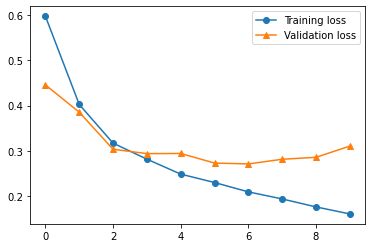

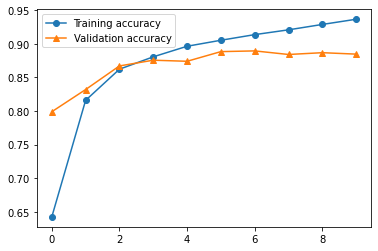

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=[6,4])
plt.plot(history_lstm.history['loss'], marker= 'o', label='Training loss')
plt.plot(history_lstm.history['val_loss'], marker='^', label='Validation loss')
_=plt.legend()

plt.figure(figsize=[6,4])
plt.plot(history_lstm.history['acc'], marker= 'o', label='Training accuracy')
plt.plot(history_lstm.history['val_acc'], marker='^', label='Validation accuracy')
_=plt.legend()

We see that, training and validation losses decrease in a well behaved manner and training and validation accuracies increase in a well behaved manner. They start to show signs of overfitting at around epoch 7. So we stop early at epoch 10.

This good results are directly linked to the ability of LSTMs to retain information over long contexts, which is essential for summarizing the whole text. Also, due to the gated channels, gradient can flow back easily in the backward pass and we do not run into vanishing and exploding gradient problems.

Now let's do the final evaluation on the test set.

In [34]:
loss_lstm, acc_lstm= model.evaluate(X_test, Y_test)
print(f'Test accuracy for LSTM = {acc_lstm:0.3%}')

782/782 [==============================] - 7s 9ms/step - loss: 0.2985 - acc: 0.8876
Test accuracy for LSTM = 88.764%


We see that we get similar good accuracy on the test set.



# Task 2

## Preparing pretrained word embeddings
We will use the GloVe word embeddings. These embeddings are openly available at:

https://nlp.stanford.edu/projects/glove/

We will (downlad and) create a dictionary of words mapping to their corresponding (NumPy) vector embeddings.

In [35]:
import os

embedding_dim = 100

embedding_file_path = f'glove.6B.{embedding_dim}d.txt'

if not os.path.exists(embedding_file_path):
    !wget http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip

embeddings_index = {}
with open(embedding_file_path, 'r', encoding="utf-8") as f:
    for line in tqdm(f):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("\nFound %s word vectors." % len(embeddings_index))


400000it [00:14, 27909.56it/s]


Found 400000 word vectors.


## Cosine Similarity

We will first define a function to calculate cosine similarity between word pairs.

In [38]:

def cosine_similarity(word1, word2):
    embedding1 = embeddings_index[word1]
    embedding2 = embeddings_index[word2]

    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    dotp = np.dot(embedding1,embedding2)

    return dotp/(norm1*norm2)

Let us now test a few word pairs.

In [71]:
word_pairs = [
    ('create','make'),
    ('this', 'is'),
    ('earth', 'moon'),
    ('build', 'destroy'),
    ('this', 'at'),
    ('red', 'blue'),
    ('round','square'),
    ('good', 'prolong'),
    ('robot', 'omnipresent'),
    ('africa', 'mormon'),
    ('prometheus','bowl'),
    ('procrastinate','hi'),
    ('humanoid', 'gaslight'),
    ('arachnid', 'bounce')
]

for word1, word2 in word_pairs:
    print(f'Cosine similarity between "{word1}" and "{word2}" = {cosine_similarity(word1,word2):0.5f}')

Cosine similarity between "create" and "make" = 0.76462
Cosine similarity between "this" and "is" = 0.85617
Cosine similarity between "earth" and "moon" = 0.68764
Cosine similarity between "build" and "destroy" = 0.60375
Cosine similarity between "this" and "at" = 0.67490
Cosine similarity between "red" and "blue" = 0.84351
Cosine similarity between "round" and "square" = 0.31396
Cosine similarity between "good" and "prolong" = 0.16875
Cosine similarity between "robot" and "omnipresent" = 0.09539
Cosine similarity between "africa" and "mormon" = 0.04618
Cosine similarity between "prometheus" and "bowl" = 0.09001
Cosine similarity between "procrastinate" and "hi" = -0.08090
Cosine similarity between "humanoid" and "gaslight" = -0.19878
Cosine similarity between "arachnid" and "bounce" = -0.19594


## Dissimilarity based on distance

We will define a normalized dissimilarity metric based on the distance between the word pairs in the eueclidean distance of their coresponding embeddings in the embedding space. However, distances are unbounded measures and without any context they are hard to interpret. So we first look at the distribution of the distances.

We randomly sample 100000 pairs of words and create a histogram of their distances.

In [88]:
words = np.array(list(embeddings_index.keys()))
random_pairs = np.random.randint(low=0,high=len(words),size=(100000,2),dtype=int)
sampled_distances = np.array(list(np.linalg.norm(embeddings_index[words[i1]]-embeddings_index[words[i2]]) 
                            for i1, i2 in random_pairs))

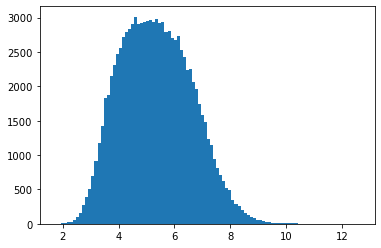

In [89]:
_=plt.hist(sampled_distances,bins=100)

We see that we get a bell shaped curve which should be related to Chi-squred distribution. However, we will not try to fit/assume any distribution for word pairs, rather directly use the emperical distribution of the sampled pairs.

We will define a dissimilarity metric based on the percentile of the distance between a word pair in the distribution of distances.

**Interpretation of this dissimilarity metric**: A dissimilarity of 0.9 would mean that 90% of all word pairs have smaller or equal distances w.r.t. the given word pair in the embedding space.

In [90]:
from scipy.stats import percentileofscore

def distance_dissimilarity(word1, word2):
    distance = np.linalg.norm(embeddings_index[word1]-embeddings_index[word2])
    return percentileofscore(sampled_distances, distance)/100.


Now let us test the dissimilarity metric on some word pairs.

In [91]:
word_pairs = [
    ('create','make'),
    ('this', 'is'),
    ('earth', 'moon'),
    ('build', 'destroy'),
    ('this', 'at'),
    ('red', 'blue'),
    ('round','square'),
    ('good', 'prolong'),
    ('robot', 'omnipresent'),
    ('africa', 'mormon'),
    ('prometheus','bowl'),
    ('procrastinate','hi'),
    ('humanoid', 'gaslight'),
    ('arachnid', 'bounce')
]

for word1, word2 in word_pairs:
    print(f'Dissimilarity between "{word1}" and "{word2}" = {distance_dissimilarity(word1,word2):0.5f}')

Dissimilarity between "create" and "make" = 0.11334
Dissimilarity between "this" and "is" = 0.02532
Dissimilarity between "earth" and "moon" = 0.32941
Dissimilarity between "build" and "destroy" = 0.37435
Dissimilarity between "this" and "at" = 0.40823
Dissimilarity between "red" and "blue" = 0.03834
Dissimilarity between "round" and "square" = 0.91717
Dissimilarity between "good" and "prolong" = 0.84805
Dissimilarity between "robot" and "omnipresent" = 0.75218
Dissimilarity between "africa" and "mormon" = 0.97999
Dissimilarity between "prometheus" and "bowl" = 0.97595
Dissimilarity between "procrastinate" and "hi" = 0.95641
Dissimilarity between "humanoid" and "gaslight" = 0.97877
Dissimilarity between "arachnid" and "bounce" = 0.71977


We see that this dissimilarity metric does indeed convey the opposite sense of the similarity metric.